In [2]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers, utils,callbacks
import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib

## Pipeline with Basic CNN model

In [3]:
# Download latest version
raw_data_path = "/Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data"
if os.path.exists(raw_data_path) and len(os.listdir(raw_data_path)) > 1:
    print(f'Datasets already downloaded ')
else:
    kaggle.api.dataset_download_files(
        "yangsangtai/tiny-genimage",
        path="/Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data",
        unzip=True
    )

Datasets already downloaded 


In [4]:
datasets = os.listdir(raw_data_path)
available_datasets = []
for dataset in datasets:
   train_path= os.path.join(raw_data_path,dataset,"train")
   if os.path.exists(train_path):
       available_datasets.append(dataset)
   else:
       print(f"{dataset} is available")

print(f"There are {len(available_datasets)} datasets available.")
print(f"they are {available_datasets}")

.DS_Store is available
There are 7 datasets available.
they are ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']


In [5]:
picture_path = os.path.join(raw_data_path,"imagenet_ai_0419_biggan","train","ai","000_biggan_00093.png")
img = Image.open(picture_path)
img.verify
width, height = img.size
img_array  = np.array(img)
std_pic = np.std(img_array)
std_pic
width

128

In [6]:
# step 1 : check if picturea are valid
def check_image_valid(image_path):
    try:
        img = Image.open(image_path)
        # check if the image is valid
        img.verify()
        img = Image.open(image_path)
        # conver image to RGB
        img = img.convert(mode="RGB")
        # check the size of image
        width,height = img.size
        if width <32 or height <32:
            print(f"This picture :{image_path} is too samll")
            return False
        # check the content of image
        img_array = np.array(img)
        if np.std(img_array)<1 :
            print(f"This picture :{image_path} has no content")
            return False
        return True
    except Exception as e:
        print(str(e))
        return False


In [9]:
# step 2 : clean the raw datasets
def clean_datasets(base_path,dataset_name):

    stats = {
    "total": 0,
    "valid" : 0,
    "invalid": 0,
    'removed': []
    }
    dataset_path = os.path.join(base_path,dataset_name)

    for split in ['train','val']:
        split_path = os.path.join(dataset_path,split)
        if not os.path.exists(split_path):
            continue
        for class_name in ['ai','nature']:
            class_path = os.path.join(split_path,class_name)
            if not os.path.exists(class_path):
                continue
            print(f"We are checking {dataset_path}/{split}/{class_name}")

            # check all the pictures of current directory

            image_files = [f for f in os.listdir(class_path)]

            for image_file in image_files:
                image_path = os.path.join(class_path,image_file)
                stats['total']+=1
                status = check_image_valid(image_path)
                if status == True:
                    stats['valid'] +=1
                else:
                    stats['invalid']+=1
                    stats['removed'].append(f"{image_file}")
                    try:
                        # os.remove(image_path)
                        print(f"{image_path} is invalid")
                    except Exception as e:
                        print(f"{image_path} cannot be removed")

    print(f"Stats :")
    print(f"There are total {stats['total']} pictures")
    print(f"There are {stats['valid']} valid pictures")
    print(f"There are {stats['invalid']} invalid pictures")
    return stats

In [10]:
all_stats = {}
for dataset in available_datasets:
    all_stats[dataset] = clean_datasets(raw_data_path,dataset)

We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/train/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/train/nature
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/val/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/val/nature
Stats :
There are total 4999 pictures
There are 4999 valid pictures
There are 0 invalid pictures
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/train/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/train/nature
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/val/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/val/nature
Stats :
There are total 5000 pictures
There are 5000 valid pictures

In [11]:
all_stats

{'imagenet_glide': {'total': 4999, 'valid': 4999, 'invalid': 0, 'removed': []},
 'imagenet_midjourney': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0424_wukong': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0508_adm': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0424_sdv5': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0419_vqdm': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0419_biggan': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []}}

In [12]:
def get_image_hash(image_path):
    """
    Calculate the hash value
    """
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

In [13]:
# step 3 : Remove duplicates picture
# TODO : need to be completed
seen_hash = {}
duplicates = []
for dataset in available_datasets:
    dataset_path = os.path.join(raw_data_path,dataset)
    print(dataset_path)
    if not os.path.exists(dataset_path):
        continue
    for split in ["train","val"]:
        for class_name in ["ai","nature"]:
            class_path = os.path.join(dataset_path,split,class_name)
            if not os.path.exists(class_path):
                continue
            for img_file in os.listdir(class_path):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue
                image_path = os.path.join(class_path,img_file)
                image_hash = get_image_hash(image_path)
                print(image_hash)
                # TODO: need to modify this part that can remove duplciate by using hash

/Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide
391b4b98540de0a8c7df159e8529ba9e
d8d5bf922e0132b227f6d13d2ef7e5c6
ab3dd574c626ee06eecd2344925177dc
6ba5f2cbff01d52d1bfed7c919d24ee2
530b8b6749f81bdd282a6f8fb885381c
e24ae74da80732410513f877823f5a0d
1b1a21be7c753501587b8b19ae28b0c4
25fc9a73c14b8e90aca441a8e3e2555a
1b23248dddd36fe1ee17f12c121ea572
f9b29fdd2bd7b5e166480107fc2f7845
851b74a87a2c41feb42e8ea4672aee3b
3b46b9768d22021b51fafaf413968099
6b0175c2c204f11af4031c694f9215bb
c36477cdb724d68612f96510205abc70
fb43a75c4ee919845c45c0c4406852a7
ec76d96e2aa29565c34172c806e150a9
636b9885760b29b1228572027f88a70c
b3bc71d4203cf58714c91e7fa376ebd7
e2fa4f301fbe29d565649c0d4ae4d3e0
9eedf80ffc21f47f2ecbcde408bdd3b4
1cef258683a3a9f0d3f0f0ba99c232ae
de2bb85c874b240c2df1e39c4e21883f
592865d4c41ebc17466a84a9f455d7b8
6079ddad64338c56f46b3b257c7ad3b2
55997fb1720c9795349d53f1f1132ee4
b6f371dc34bcc1d142210d025a7d08cd
fee04d572b099dc497e795b6b8238703
4d2da3dba7c24d67ccb8365a8c220082


In [14]:
# step 4 : Merge cleanned dataset to a new folder
# create the directories
merged_path = 'merged_data'
merged_train_path = os.path.join(merged_path, 'train')
merged_val_path = os.path.join(merged_path, 'val')
for split in ['train', 'val']:
    for class_name in ['ai', 'nature']:
        os.makedirs(os.path.join(merged_path, split, class_name), exist_ok=True)

In [15]:
def merge_clean_datasets(dataset,base_path,merged_path):

    stats = {
    'train':{'ai':0, 'nature':0},
    'val':{'ai':0,'nature':0}
    }
    # fdfd
    for dataset in available_datasets:
        dataset_path = os.path.join(base_path,dataset)
        if not os.path.exists(dataset_path):
            continue
        for split in ['train','val']:
            split_path = os.path.join(dataset_path,split)
            if not os.path.exists(split_path):
                continue
            for class_name in ['ai','nature']:
                class_path = os.path.join(split_path,class_name)
                if not os.path.exists(class_path):
                    continue

                target_path = os.path.join(merged_path,split,class_name)
                copied = 0
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file,dst_file)
                        copied += 1
                        stats[split][class_name] += 1
    print(stats)
    return stats

In [16]:
# merge datasets to target directory
for dataset in available_datasets:
   merge_stats =  merge_clean_datasets(dataset,raw_data_path,merged_path)

{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}


In [17]:
# step 5 : Load dataset
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    merged_train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    seed=42

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    merged_val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)


Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.


In [39]:
# TODO: data augmentation, AUTOTUNE, prefetch

In [18]:
train_ds.class_names

['ai', 'nature']

In [19]:
normalize = layers.Rescaling(1./255)

In [20]:
train_ds = train_ds.map(
    lambda x , y : (normalize(x),y)
)

In [21]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

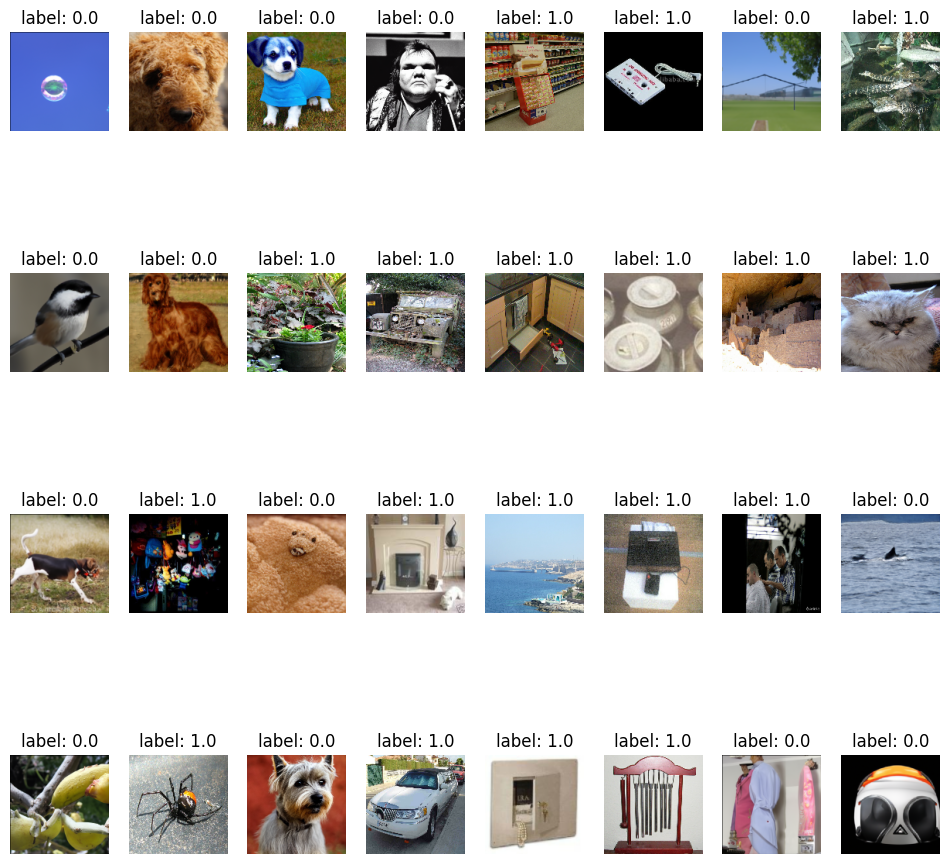

2026-02-10 20:02:00.096826: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:

for images, labels in train_ds.take(1):
    batch_size = images.shape[0]

    plt.figure(figsize=(12, 12))
    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)  #
        plt.imshow(images[i].numpy())
        plt.title(f"label: {labels[i].numpy()[0]}")
        plt.axis("off")
    plt.show()

In [22]:
val_ds = val_ds.map(
    lambda x , y : (normalize(x),y)
)

In [23]:
model = Sequential()

model.add(Input((128, 128, 3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
# And we perform the prediction using sigmoid

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [50]:
%%time
history_basic_cnn = model.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds
        )

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 141s 159ms/step - accuracy: 0.6570 - loss: 0.6153 - val_accuracy: 0.7669 - val_loss: 0.4970
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.7666 - loss: 0.5014 - val_accuracy: 0.8030 - val_loss: 0.4373
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.7942 - loss: 0.4551 - val_accuracy: 0.8074 - val_loss: 0.4266
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 135s 154ms/step - accuracy: 0.8117 - loss: 0.4227 - val_accuracy: 0.8197 - val_loss: 0.4084
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 135s 155ms/step - accuracy: 0.8251 - loss: 0.3904 - val_accuracy: 0.8244 - val_loss: 0.3915
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.8404 - loss: 0.3639 - val_accuracy: 0.8236 - val_loss: 0.4131
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 134s 153ms/step - accuracy: 0.8530 - loss: 0.3344 - val_accuracy: 0.8370 - val_loss: 0.3921
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 144s 164ms/step - accuracy: 0.8657 -

In [26]:
history_basic_cnn.history

NameError: name 'history_basic_cnn' is not defined

In [48]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


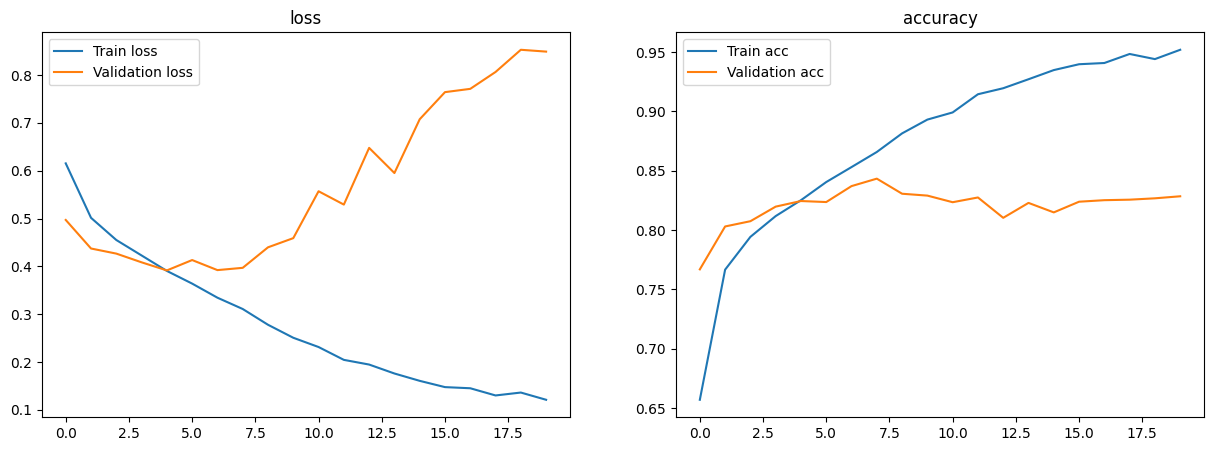

In [63]:
plot_history(history_basic_cnn)

In [55]:
# Compare the performance of 2 models
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')


    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

In [27]:
model.save("basic_cnn.keras")

In [28]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [29]:
import requests
from io import BytesIO

def get_image(url):
    response = requests.get(url=url)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


In [30]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def image_predict(url,model):
    img = get_image(url)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 128, 128, 3))
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    result = round(prediction[0][0],2)
    plt.imshow(img)
    plt.axis('off')
    if result<0.5:
        print("The picture is AI generated")
    if result>=0.5:
        print("The picture is not AI generated")

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
The picture is AI generated


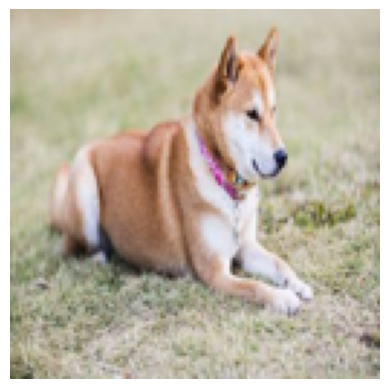

In [31]:
image_predict(dog2,model)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The picture is AI generated


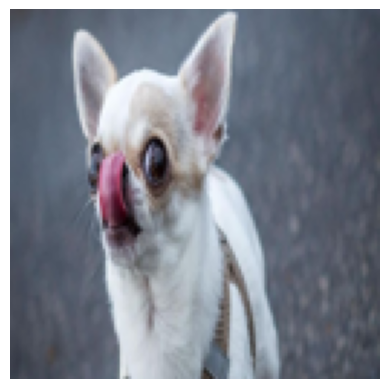

In [32]:
image_predict(dog,model)

## Data Augmentation

In [34]:
img_size = (128, 128)
batch_size = 32
print(merged_train_path)
print(merged_val_path)
train_ds_aug= tf.keras.utils.image_dataset_from_directory(
    merged_train_path,
    labels = 'inferred',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    verbose = 1,
    seed=42

)

val_ds_aug= tf.keras.utils.image_dataset_from_directory(
    merged_val_path,
    labels = 'inferred',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    verbose = 1,
    seed=42
)


merged_data/train
merged_data/val
Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.


In [35]:
train_ds_aug.class_names

['ai', 'nature']

In [36]:
train_ds_aug

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [37]:
train_ds_aug.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

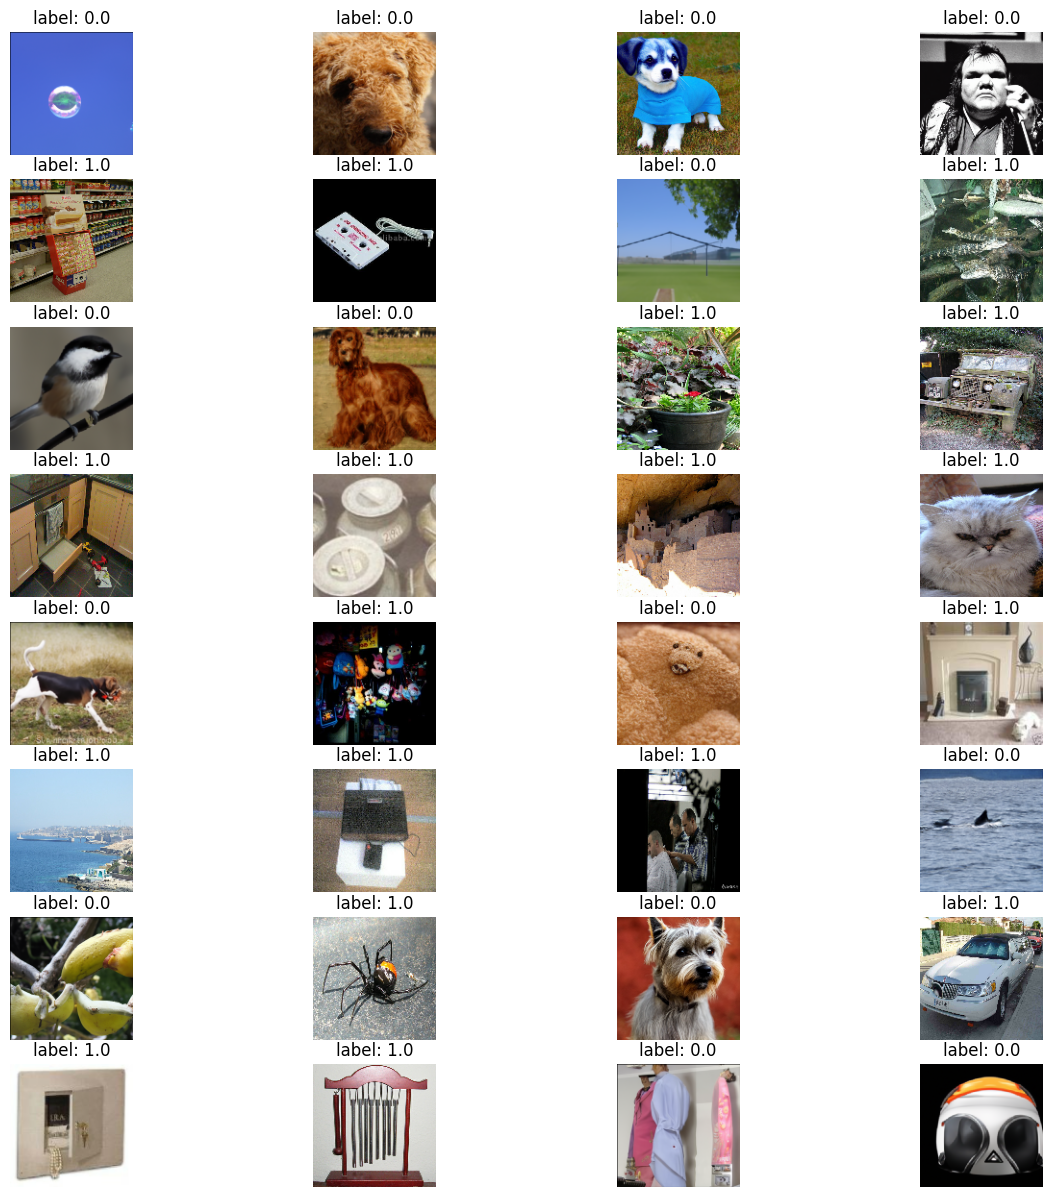

2026-02-12 02:00:02.963500: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        plt.subplot(8,4,i+1)
        plt.imshow(images[i])
        plt.title(f"label: {labels[i].numpy()[0]}")
        plt.axis('off')
    plt.show()

In [39]:
data_augmentation = Sequential(
    [
    layers.RandomFlip(mode="horizontal",seed=42),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
    ]
)

In [ ]:
model_augmentation= Sequential(
    [
        #input layer
        layers.Input(shape=(128, 128, 3)),
        # augumentation layer
        data_augmentation,
        # rescale
        layers.Rescaling(1./255),
        # convolutional layer
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        layers.Dropout(0.3),

        layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        layers.Dropout(0.3),

        layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        layers.Dropout(0.3),

        layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        layers.Dropout(0.3),

        # flatten
        layers.Flatten(),
        layers.Dense(128,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # output layer
        layers.Dense(1, activation='sigmoid')
    ]
)

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
adam = optimizers.Adam(learning_rate = 0.001)
model_augmentation.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [43]:
MODEL = "CNN_augmentaiton.keras"
modelCheckpoint = callbacks.ModelCheckpoint(filepath=MODEL,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.1,
                                        patience=3,
                                        verbose=1,
                                        min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss',
                                       patience=10,
                                       verbose=0,
                                       restore_best_weights=True)

In [ ]:
# TODO:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
# val_ds = val_ds.cache().prefetch(AUTOTUNE)


NameError: name 'tf' is not defined

In [45]:
%%time
history_model_aug = model.fit(
        train_ds_aug,
        epochs=20,
        validation_data=val_ds_aug,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
        )

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 150s 171ms/step - accuracy: 0.5964 - loss: 0.6601 - val_accuracy: 0.6454 - val_loss: 0.6247 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 163s 187ms/step - accuracy: 0.7344 - loss: 0.5480 - val_accuracy: 0.7563 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 142s 162ms/step - accuracy: 0.7643 - loss: 0.5021 - val_accuracy: 0.7714 - val_loss: 0.4954 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 167s 190ms/step - accuracy: 0.7838 - loss: 0.4709 - val_accuracy: 0.7844 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 194s 222ms/step - accuracy: 0.7928 - loss: 0.4530 - val_accuracy: 0.7999 - val_loss: 0.4264 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 151s 172ms/step - accuracy: 0.8076 - loss: 0.4247 - val_accuracy: 0.7931 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 136s 155ms/step - accura

In [ ]:
# TODO:
"""
test_set
Precision, Recall, F1-score
Confusion Matrix
ROC Curve + AUC (Professional Metric)
Check for Overfitting (train loss vs evaluation loss)
"""

In [51]:
history_model_aug.history

{'accuracy': [0.5964498519897461,
  0.7343833446502686,
  0.7642772793769836,
  0.7838494181632996,
  0.7928497195243835,
  0.8075645565986633,
  0.8102432489395142,
  0.8216007947921753,
  0.8294939398765564,
  0.8382084965705872,
  0.8458516597747803,
  0.857852041721344,
  0.8688881993293762,
  0.8933890461921692,
  0.9078538417816162,
  0.9165327548980713,
  0.9251759052276611,
  0.9242115616798401,
  0.9281759858131409,
  0.9283545613288879],
 'loss': [0.6600521206855774,
  0.5480229258537292,
  0.5021358132362366,
  0.4708908200263977,
  0.453025758266449,
  0.42465174198150635,
  0.41819462180137634,
  0.39469969272613525,
  0.375490665435791,
  0.3566259443759918,
  0.3426462709903717,
  0.3232300281524658,
  0.2933028042316437,
  0.2437136024236679,
  0.20821073651313782,
  0.18884558975696564,
  0.17113801836967468,
  0.17053374648094177,
  0.1659335047006607,
  0.16375689208507538],
 'val_accuracy': [0.6454285979270935,
  0.7562857270240784,
  0.7714285850524902,
  0.7844285

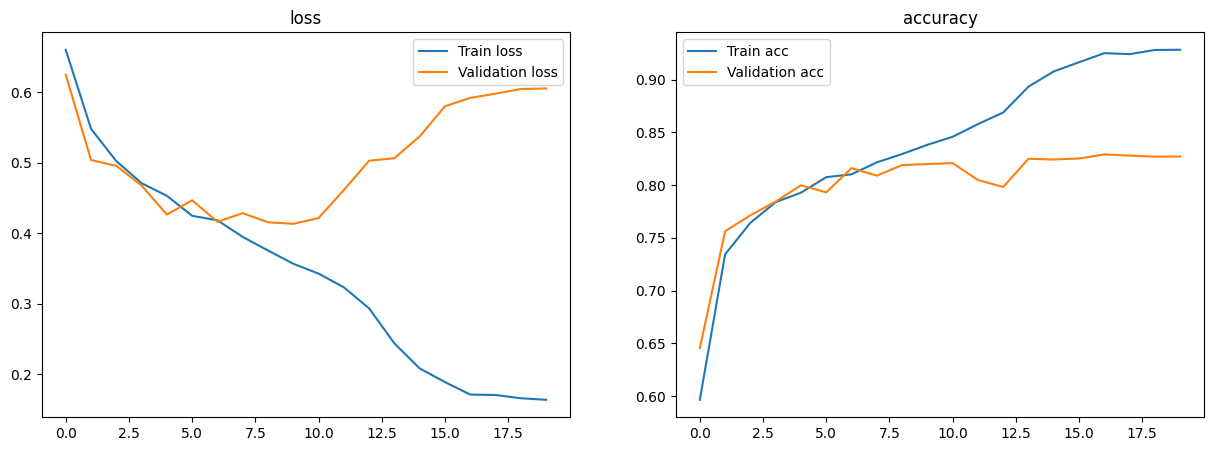

In [56]:
plot_history(history_model_aug)